In [294]:
# install.packages("stargazer")
#install.packages("mvtnorm")
#install.packages("emmeans")
#install.packages("plyr")
#install.packages("magrittr")
#install.packages("dplyr")
#install.packages("svglite")
#install.packages("gridExtra")

In [295]:
library("reshape2")
library("stargazer")
library("ggplot2")
library("magrittr")
library("plyr")
library("dplyr")
library("grid")
library("gridExtra")
#library("svglite")
#library("emmeans")

In [296]:
absPath = '/home/angela/padding_EBI/'

In [297]:
file_scores <- "scores_final.csv"
file_accuracy <- "accu_final.csv"

### Defining functions

In [298]:
postproc_lm <- function(lm_res){
    sm <- summary(lm_res)
    sm_df <- as.data.frame(sm$coefficients)
    colnames(sm_df) <- c("Estimate", "Std.Error", "t.value", "p_val")
    sm_df["p_adjusted"] = p.adjust(sm_df$p_val, method = "fdr")
    index <- sm_df["p_adjusted"] >= 0.05
    #sm_df$Estimate[index] <- 0
    return(sm_df)
}

dividing_rownames <- function(group, df){
    names <- c()
    estimates <- c()
    pvals <- c()
    indices <- grep(group,rownames(df))
    subgroup <- rownames(df)[indices]
    for (i in 1:length(subgroup)){
        sg <- unlist(strsplit(subgroup[i], group)[1])[2]
        names <- c(names, sg)
        estimates <- c(estimates, df[subgroup[i], "Estimate"])
        pvals <- c(pvals, df[subgroup[i], "p_adjusted"])
              }
    mini_df <- data.frame("estimates"=estimates, "p_valor"=pvals)
    mini_df$significant <- mini_df["p_valor"] < 0.05
    rownames(mini_df) <- names
    mini_df[group] <- rownames(mini_df)
    mini_df["x"] <- 1
    return(mini_df)
}    

values_significant <- c("black", NA)
names(values_significant) <- c(TRUE, FALSE)

separating_interactions <- function(group1, group2, df){
    estimates_list <- c()
    xs <- c()
    ys <- c()
    interactions <- grep(":", rownames(df))
    df_int <- df[interactions,]
    df_esti <- df[-interactions,]
    pvals_list <- c()
    for (i in 1:length(rownames(df_int))){
        sg <- unlist(strsplit(rownames(df_int)[i], ":")[1])
        x <- unlist(strsplit(sg[1], group1)[1])[2]
        y <- unlist(strsplit(sg[2], group2)[1])[2]
        estimates_list <- c(estimates_list, df[rownames(df_int)[i], "Estimate"])
        pvals_list <- c(pvals_list, df_int[rownames(df_int)[i], "p_adjusted"])
        xs <- c(xs, x)
        ys <- c(ys, y)
        }
    interactions_df <- data.frame("estimates"=estimates_list, "x"=xs, "y"=ys, "p_val"=pvals_list)
    interactions_df$significant <- interactions_df$p_val < 0.05
    newList <- list("estimates_df"=df_esti, "interactions_df"=interactions_df)
    return(newList)

}

plotting_additive <- function(group, df){
    ggplot(df, aes_string( x="x", y=group)) +
geom_tile(aes(fill = estimates), colour = "white", height=1, width=1) + 
geom_tile(aes(color=significant), fill=NA, size=0.5, height=1, width=1) + 
scale_fill_gradient2(limits=c(-1, 1)) + 
scale_color_manual(values= values_significant) +  
theme_bw() + 
theme(axis.title.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank(),
     axis.title.y=element_blank(), axis.text.y=element_text(size=11))+ 
coord_equal()
}

plotting_interactions <- function(df){
    ggplot(df$interactions_df, aes( x=x, y=y)) +
geom_tile(aes(fill = estimates), colour = "white") + 
geom_tile(aes(color=significant), fill=NA, size=0.5) + 
scale_fill_gradient2(limits=c(-1, 1)) + 
scale_color_manual(values= values_significant) +  
theme_bw() + 
theme(axis.title.x=element_blank(), axis.ticks.x=element_blank(),
     axis.title.y=element_blank(), axis.text.y=element_text(size=11),
     axis.text.x=element_text(size=10)) +
coord_equal()
    
}


plot_coefs_inter <- function(mod, method.adjust = "fdr", q.signif = .05) {
    df.coef <- as.data.frame(summary(mod)$coef)
    
    nm <- rownames(df.coef)
    nm.split <- strsplit(nm, split = ":")
    
    df.coef$x1 <- sapply(nm.split, function(x) x[[1]])
    df.coef$x2 <- sapply(nm.split, function(x) {
        if (length(x) < 2) return("No interaction")
        x[[2]]
    })
    df.coef$p.adjust <- p.adjust(df.coef$`Pr(>|t|)`, method = method.adjust)
    df.coef$Significance <- ifelse(
        df.coef$p.adjust < q.signif, 
        paste0("q<", q.signif), paste0("q>=", q.signif))
                    
    values_significant <- c("black", NA)
    names(values_significant) <- c(paste0("q<", q.signif), paste0("q>=", q.signif))
    
    
    # if (is.null(order.vars)) {
    #     message("order.vars not supplied. Sorting alphabetically...")
    #     order.vars <- unique(sort(sapply(nm.split, function(x) x[[1]])))
    # }
    
    var.factor <- mod$xlevels
    df.factor <- plyr::ldply(
        names(var.factor), 
        function(x) {
            data.frame(
                var.name = x, 
                var.level = var.factor[[x]], 
                x = paste0(x, var.factor[[x]]), 
                stringsAsFactors = FALSE
            )
        }
    )
                         
    labs_new <- c("arch.", "enz", "Int.", "pad.")
    names(labs_new) <- c("architecture", "enz_type", "(Intercept)", "type_padding")
    
    df.coef %<>% 
        join(rename_all(df.factor, function(x) paste0(x, "1"))) %>%
        join(rename_all(df.factor, function(x) paste0(x, "2"))) %>%
        mutate(facet1 = ifelse(is.na(var.name1), x1, var.name1), 
               facet2 = ifelse(is.na(var.name2), x2, var.name2), 
               tick1 = ifelse(is.na(var.level1), x1, var.level1), 
               tick2 = ifelse(is.na(var.level2), x2, var.level2))
    
    ggplot(df.coef, aes(x = tick1, y = tick2 
                        #,fill = Estimate 
                        #,colour = Significance
                       )) +
        #geom_tile(lwd = 2) +
        geom_tile(aes(fill=Estimate)) +
        geom_tile(aes(color=Significance), fill=NA, size=0.5) +
        scale_colour_manual(values = values_significant) +
        scale_fill_gradient2(low = "cornflowerblue", mid = "gray90", high = "indianred", limits=c(-1, 1)) +
        facet_grid(facet2~facet1, scales = "free", space = "free", 
                   labeller=labeller(facet1=labs_new)) +
        theme_bw() +
        theme(aspect.ratio = 1, 
              panel.grid = element_blank(), 
              strip.text.y = element_text(angle = 0), 
              axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)
              #, legend.position = "none"
             #strip.text.x = element_text(size=9)
             ) +
        # he intentado que el cuadrado de la leyenda salga bien pero esta pocho
        # guides(colour = guide_legend(fill = "white")) + 
        xlab("") +
        ylab("")
}
                    

#mod <- lm(Sepal.Length ~ Sepal.Width + Species*Petal.Width, data = iris)
#plot_coefs_inter(mod)
#plot_coefs_inter(mod, q.signif = 1e-5)

# Task 1

In [299]:
task <- "task1/"

path_scores_task1 <- paste0(absPath, "data/results/", task, file_scores)
#path_accu_task1 <- paste0(absPath, "data/results/", task, file_accuracy)

scores_task1 <- read.csv(file=path_scores_task1, header=TRUE, sep=",")
#accu_task1 <- read.csv(file=path_accu_task1, header=TRUE, sep=",")

## Scores

In [300]:
scores_task1[0:5,]
scores_task1$X <- NULL
#filtering 
scores_task1 <- scores_task1[scores_task1$enz_type %in% c(0,1),]
sapply(scores_task1, class)
# habria que hacer un unmelt de variable-value
scores_task1_dcasted <- dcast(data = scores_task1,formula = enz_type+index+type_padding+architecture~variable,
                              fun.aggregate = sum,value.var = "value")
#tengo que cambiar el nombre de f1-score
colnames(scores_task1_dcasted) <- c("enz_type", "index", "type_padding", "architecture", "f1_score",
                                    "precision", "recall")
scores_task1_dcasted[0:5,]

X,enz_type,index,type_padding,architecture,variable,value
<int>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>
0,0,0,post_padding,1_conv,f1-score,0.8548043
1,1,0,post_padding,1_conv,f1-score,0.8642715
2,micro avg,0,post_padding,1_conv,f1-score,0.8596974
3,macro avg,0,post_padding,1_conv,f1-score,0.8595379
4,weighted avg,0,post_padding,1_conv,f1-score,0.8600099


enz_type        index type_padding architecture     variable        value 
    "factor"    "integer"     "factor"     "factor"     "factor"    "numeric"

enz_type,index,type_padding,architecture,f1_score,precision,recall
<fct>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
0,0,aug_padding,1_conv,0.7512593,0.6471795,0.8952308
0,0,aug_padding,bi_lstm,0.7167895,0.5736383,0.9551457
0,0,aug_padding,only_denses,0.8760426,0.8434343,0.9112736
0,0,aug_padding,stack_conv,0.7811460,0.6844007,0.9097457
0,0,ext_padding,1_conv,0.8403179,0.7971213,0.8884645


## changing reference

In [301]:
scores_task1_dcasted$architecture <- relevel(scores_task1_dcasted$architecture, "only_denses")
scores_task1_dcasted$type_padding <- relevel(scores_task1_dcasted$type_padding, "post_padding")

## defining "complete" lm task 1 (Additive)

In [302]:
lm_f1_task1_additive <- lm(f1_score~architecture+enz_type+type_padding, data=scores_task1_dcasted)

In [303]:
summary(lm_f1_task1_additive)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding, 
    data = scores_task1_dcasted)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.72626 -0.01819  0.00412  0.02333  0.09002 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.915552   0.006112 149.794  < 2e-16 ***
architecture1_conv       -0.063287   0.004990 -12.682  < 2e-16 ***
architecturebi_lstm      -0.143906   0.004990 -28.836  < 2e-16 ***
architecturestack_conv   -0.052351   0.004990 -10.490  < 2e-16 ***
enz_type1                 0.024232   0.003529   6.867 1.58e-11 ***
type_paddingaug_padding  -0.073154   0.007058 -10.365  < 2e-16 ***
type_paddingext_padding  -0.045384   0.007058  -6.431 2.52e-10 ***
type_paddingmid_padding   0.005152   0.007058   0.730   0.4657    
type_paddingpre_padding  -0.011706   0.007058  -1.659   0.0977 .  
type_paddingrnd_padding  -0.052515   0.007058  -7.441 3.30e-13 ***
type_paddingstrf_padding -0.010308   0.

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


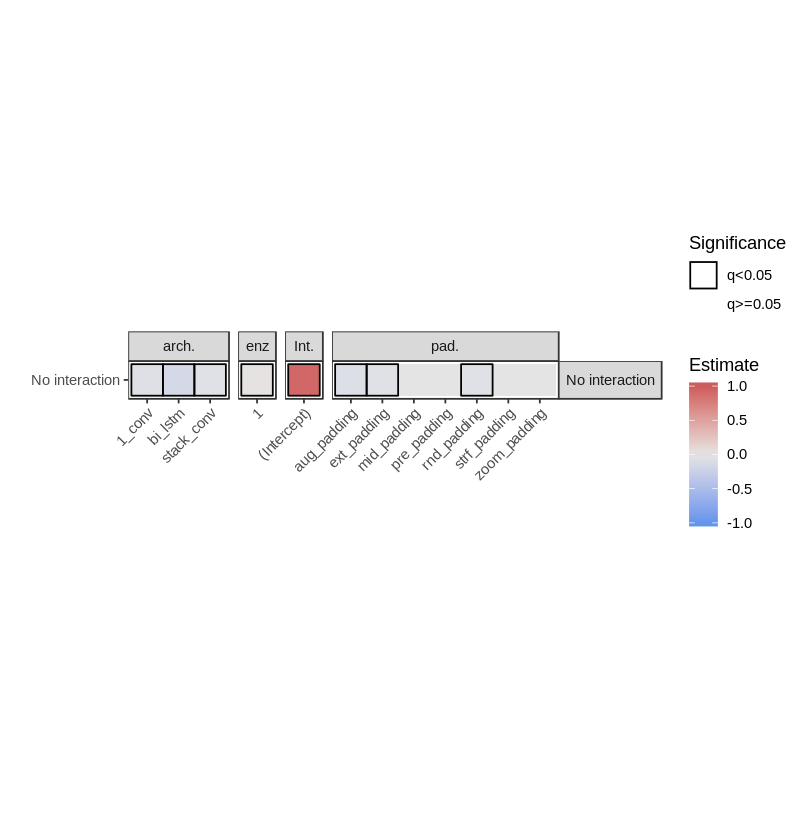

In [304]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g1_task1 = plot_coefs_inter(lm_f1_task1_additive)
g1_task1
ggsave("full_additive.eps", device="eps", path=file_path)

In [305]:
sm1_df <- postproc_lm(lm_f1_task1_additive)
sm1_df

,Estimate,Std.Error,t.value,p_val,p_adjusted
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.915552229,0.006112069,149.7941639,0.000000e+00,0.000000e+00
architecture1_conv,-0.063287318,0.004990483,-12.6816012,5.664933e-33,2.265973e-32
architecturebi_lstm,-0.143906274,0.004990483,-28.8361402,4.183409e-117,2.510045e-116
architecturestack_conv,-0.052350501,0.004990483,-10.4900665,7.837249e-24,2.351175e-23
enz_type1,0.024231756,0.003528805,6.8668457,1.580926e-11,2.710159e-11
type_paddingaug_padding,-0.073154146,0.007057609,-10.3652874,2.399845e-23,5.759629e-23
type_paddingext_padding,-0.045384439,0.007057609,-6.4305686,2.518908e-10,3.778362e-10
type_paddingmid_padding,0.005151980,0.007057609,0.7299895,4.656688e-01,4.656688e-01
type_paddingpre_padding,-0.011705948,0.007057609,-1.6586280,9.769011e-02,1.302535e-01


In [306]:
# Dividing lm in representable tiles
arch_df_1 <- dividing_rownames("architecture", sm1_df)
enz_df_1 <- dividing_rownames("enz_type", sm1_df)
pad_df_1 <- dividing_rownames("type_padding", sm1_df)

In [307]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("architecture", arch_df_1)

In [308]:
#options(repr.plot.width=2.25, repr.plot.height=3)
#plotting_additive("enz_type", enz_df_1)

In [309]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df_1)

## in SoA models, are dense paddings the same? 

In [310]:
soa_arch <- c("stack_conv", "bi_lstm")
soa_pad <- c("post_padding", "pre_padding", "mid_padding", "ext_padding")
lm_f1_task1_additive_soa <- lm(f1_score~architecture+enz_type+type_padding+type_padding:architecture, 
                               data=subset(scores_task1_dcasted, architecture %in% soa_arch & type_padding %in% soa_pad))

In [311]:
summary(lm_f1_task1_additive_soa)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding + 
    type_padding:architecture, data = subset(scores_task1_dcasted, 
    architecture %in% soa_arch & type_padding %in% soa_pad))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.63387 -0.01356  0.00976  0.02012  0.09387 

Coefficients:
                                                Estimate Std. Error t value
(Intercept)                                     0.776724   0.014281  54.387
architecturestack_conv                          0.080073   0.019042   4.205
enz_type1                                       0.044692   0.009521   4.694
type_paddingext_padding                        -0.142850   0.019042  -7.502
type_paddingmid_padding                         0.020414   0.019042   1.072
type_paddingpre_padding                        -0.014794   0.019042  -0.777
architecturestack_conv:type_paddingext_padding  0.138917   0.026929   5.159
architecturestack_conv:type_paddingmid_padding -0.025990   0.026929  -0

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


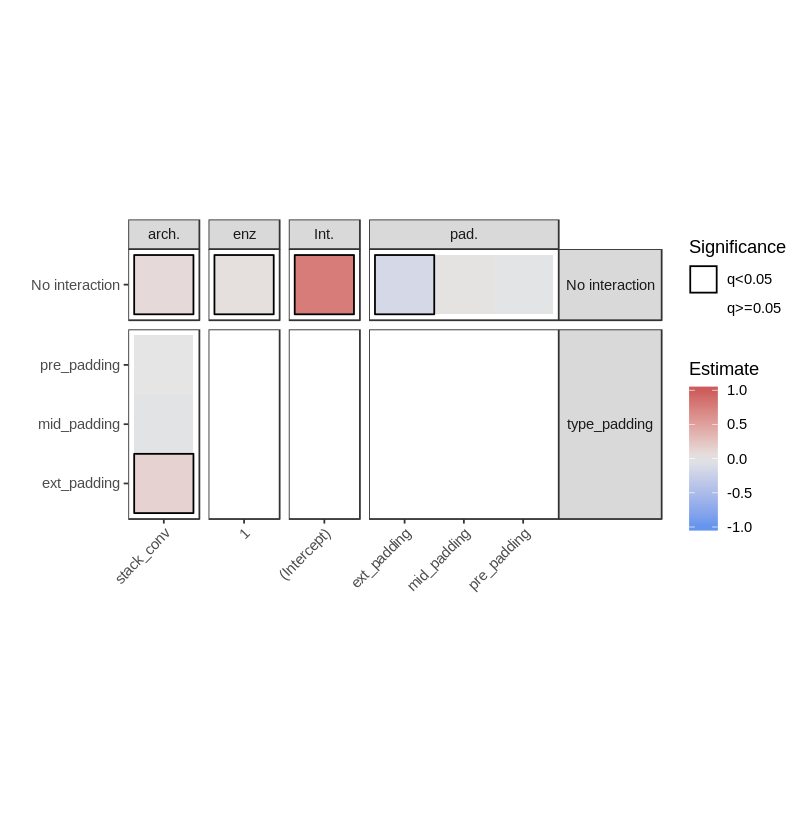

In [312]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g2_task1 = plot_coefs_inter(lm_f1_task1_additive_soa)
g2_task1
ggsave("soa_densePadding.eps", device="eps", path=file_path)


In [313]:
sm2_df <- postproc_lm(lm_f1_task1_additive_soa)
sm2_df_proc <- separating_interactions("architecture", "type_padding", sm2_df)

In [314]:
# Dividing lm in representable tiles
arch_df_2 <- dividing_rownames("architecture", sm2_df_proc$estimates_df)
enz_df_2 <- dividing_rownames("enz_type", sm2_df_proc$estimates_df)
pad_df_2 <- dividing_rownames("type_padding", sm2_df_proc$estimates_df)

In [315]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("architecture", arch_df_2)

In [316]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("enz_type", enz_df_2)

In [317]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df_2)

In [318]:
#options(repr.plot.width=4, repr.plot.height=3)
#plotting_interactions(sm2_df_proc)

## effect of sparse padding to state of the art architectures?

In [319]:
# interactions non significant
soa2_pad <- c("post_padding", "strf_padding", "rnd_padding", "zoom_padding")
lm_f1_task1_additive_soa3 <- lm(f1_score~architecture+enz_type+type_padding+type_padding:architecture, 
                               data=subset(scores_task1_dcasted, architecture %in% soa_arch & type_padding %in% soa2_pad))

In [320]:
summary(lm_f1_task1_additive_soa3)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding + 
    type_padding:architecture, data = subset(scores_task1_dcasted, 
    architecture %in% soa_arch & type_padding %in% soa2_pad))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.123549 -0.011610  0.003657  0.015111  0.047437 

Coefficients:
                                                 Estimate Std. Error t value
(Intercept)                                      0.775619   0.005419 143.118
architecturestack_conv                           0.080073   0.007226  11.081
enz_type1                                        0.046901   0.003613  12.981
type_paddingrnd_padding                         -0.052357   0.007226  -7.246
type_paddingstrf_padding                        -0.037966   0.007226  -5.254
type_paddingzoom_padding                        -0.004687   0.007226  -0.649
architecturestack_conv:type_paddingrnd_padding  -0.014559   0.010219  -1.425
architecturestack_conv:type_paddingstrf_padding  0.0

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


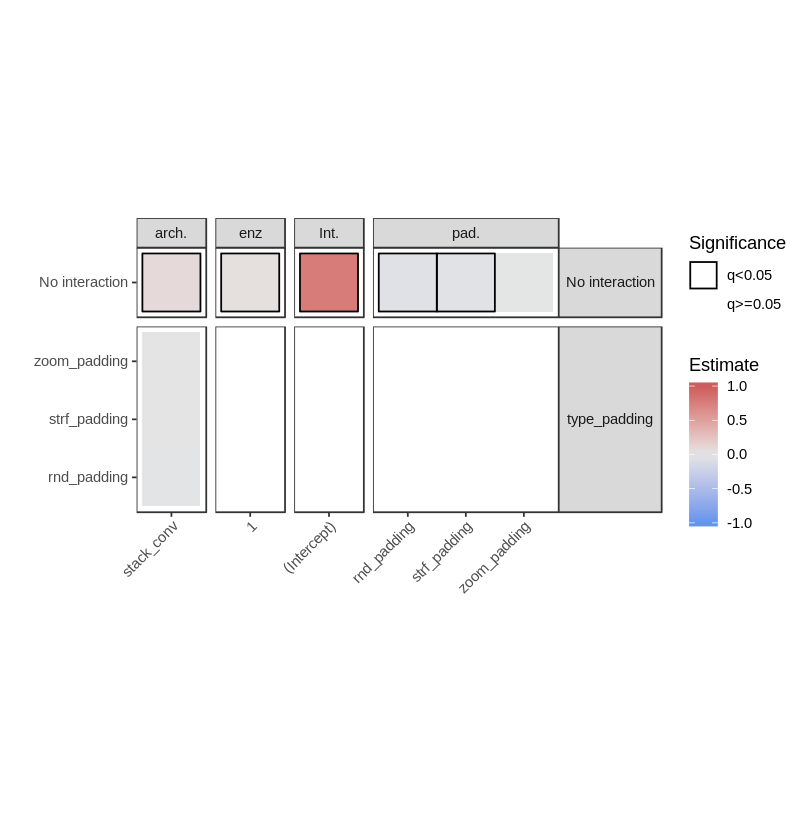

In [321]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g3_task1 = plot_coefs_inter(lm_f1_task1_additive_soa3)

g3_task1
ggsave("soa_sparsePadding.eps", device="eps", path=file_path)

In [322]:
sm3_df <- postproc_lm(lm_f1_task1_additive_soa3)
sm3_df_proc <- separating_interactions("architecture", "type_padding", sm3_df)

# Dividing lm in representable tiles
arch_df_3 <- dividing_rownames("architecture", sm3_df_proc$estimates_df)
enz_df_3 <- dividing_rownames("enz_type", sm3_df_proc$estimates_df)
pad_df_3 <- dividing_rownames("type_padding", sm3_df_proc$estimates_df)

In [323]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("architecture", arch_df_3)

In [324]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("enz_type", enz_df_3)

In [325]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df_3)

In [326]:
#options(repr.plot.width=4, repr.plot.height=3)
#plotting_interactions(sm3_df_proc)

## differences between types of padding?

In [327]:
lm_f1_task1_additive_soa4 <- lm(f1_score~enz_type+type_padding, 
                               data=subset(scores_task1_dcasted, architecture == "only_denses"))

In [328]:
summary(lm_f1_task1_additive_soa4)


Call:
lm(formula = f1_score ~ enz_type + type_padding, data = subset(scores_task1_dcasted, 
    architecture == "only_denses"))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.075505 -0.008432  0.002578  0.010467  0.031178 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.8956930  0.0038765 231.057  < 2e-16 ***
enz_type1                 0.0087738  0.0025843   3.395 0.000877 ***
type_paddingaug_padding  -0.0001935  0.0051687  -0.037 0.970191    
type_paddingext_padding  -0.0041699  0.0051687  -0.807 0.421071    
type_paddingmid_padding   0.0105087  0.0051687   2.033 0.043789 *  
type_paddingpre_padding  -0.0008379  0.0051687  -0.162 0.871442    
type_paddingrnd_padding  -0.0041826  0.0051687  -0.809 0.419664    
type_paddingstrf_padding  0.0300487  0.0051687   5.814 3.51e-08 ***
type_paddingzoom_padding -0.0067748  0.0051687  -1.311 0.191932    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


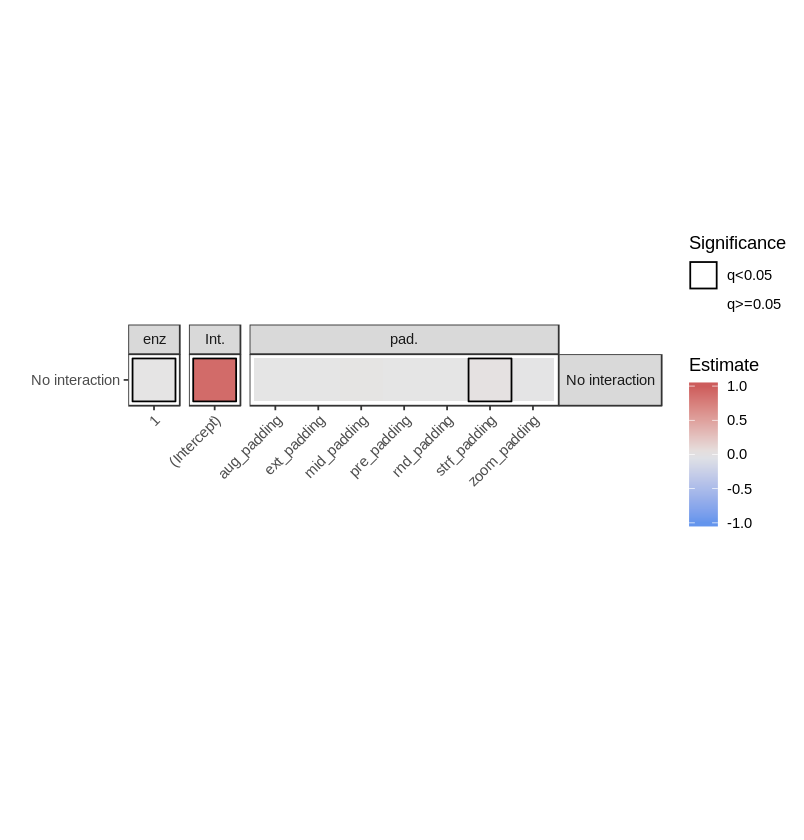

In [329]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g4_task1 <- plot_coefs_inter(lm_f1_task1_additive_soa4)
g4_task1

ggsave("typesPadding.eps", device="eps", path=file_path)

In [330]:
sm4_df <- postproc_lm(lm_f1_task1_additive_soa4)

enz_df_4 <- dividing_rownames("enz_type", sm4_df)
pad_df_4 <- dividing_rownames("type_padding", sm4_df)

In [331]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("enz_type", enz_df_4)

In [332]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df_4)

## mejoran las capas convolucionales la performance de los modelos?

In [333]:
soa_pad <- c("post_padding", "strf_padding")
lm_f1_task1_soa5 <- lm(f1_score~architecture+enz_type+type_padding+type_padding:architecture, 
                               data=subset(scores_task1_dcasted, type_padding %in% soa_pad))

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


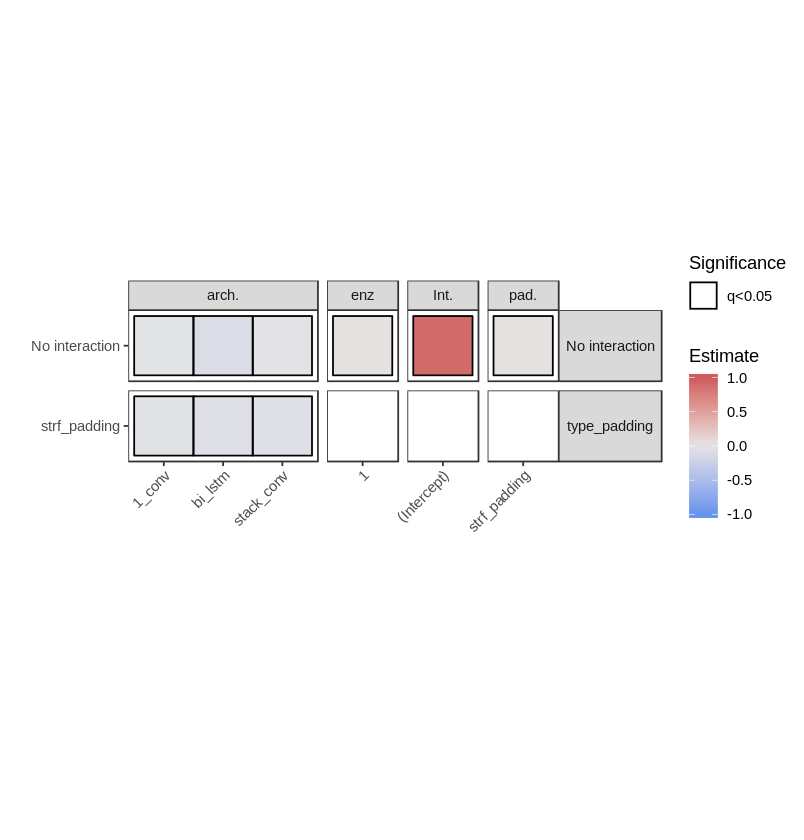

In [334]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g5_task1 <- plot_coefs_inter(lm_f1_task1_soa5)
g5_task1
ggsave("convLayers.eps", device="eps", path=file_path)


In [335]:
summary(lm_f1_task1_soa5)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding + 
    type_padding:architecture, data = subset(scores_task1_dcasted, 
    type_padding %in% soa_pad))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.133528 -0.009068 -0.000109  0.012975  0.037458 

Coefficients:
                                                 Estimate Std. Error t value
(Intercept)                                      0.886609   0.004840 183.167
architecture1_conv                              -0.027244   0.006454  -4.221
architecturebi_lstm                             -0.101010   0.006454 -15.651
architecturestack_conv                          -0.020937   0.006454  -3.244
enz_type1                                        0.026942   0.003227   8.349
type_paddingstrf_padding                         0.030049   0.006454   4.656
architecture1_conv:type_paddingstrf_padding     -0.035423   0.009127  -3.881
architecturebi_lstm:type_paddingstrf_padding    -0.068014   0.009127  -7.452
archi

In [336]:
sm5_df <- postproc_lm(lm_f1_task1_soa5)
sm5_df_proc <- separating_interactions("architecture", "type_padding", sm5_df)

In [337]:
# Dividing lm in representable tiles
arch_df_5 <- dividing_rownames("architecture", sm5_df_proc$estimates_df)
enz_df_5 <- dividing_rownames("enz_type", sm5_df_proc$estimates_df)
pad_df_5 <- dividing_rownames("type_padding", sm5_df_proc$estimates_df)

In [338]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("architecture", arch_df_5)

In [339]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("enz_type", enz_df_5)

In [340]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df_5)

In [341]:
#options(repr.plot.width=4, repr.plot.height=3)
#plotting_interactions(sm5_df_proc)

## tiene aug_padding un buen efecto? 

In [342]:
soa_pad <- c("post_padding", "strf_padding", "aug_padding")
scores_task1_dcasted_aug <- scores_task1_dcasted
scores_task1_dcasted_aug$type_padding <- relevel(scores_task1_dcasted_aug$type_padding, "aug_padding")
lm_f1_task1_soa6 <- lm(f1_score~architecture+enz_type+type_padding+type_padding:architecture, 
                               data=subset(scores_task1_dcasted_aug, type_padding %in% soa_pad))
summary(lm_f1_task1_soa6)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding + 
    type_padding:architecture, data = subset(scores_task1_dcasted_aug, 
    type_padding %in% soa_pad))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.173831 -0.012287  0.003771  0.013166  0.081870 

Coefficients:
                                                  Estimate Std. Error t value
(Intercept)                                      0.8939838  0.0071540 124.962
architecture1_conv                              -0.1438240  0.0097204 -14.796
architecturebi_lstm                             -0.1873464  0.0097204 -19.273
architecturestack_conv                          -0.1098636  0.0097204 -11.302
enz_type1                                        0.0118053  0.0039684   2.975
type_paddingpost_padding                         0.0001935  0.0097204   0.020
type_paddingstrf_padding                         0.0302421  0.0097204   3.111
architecture1_conv:type_paddingpost_padding      0.1165799  0.0137468 

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


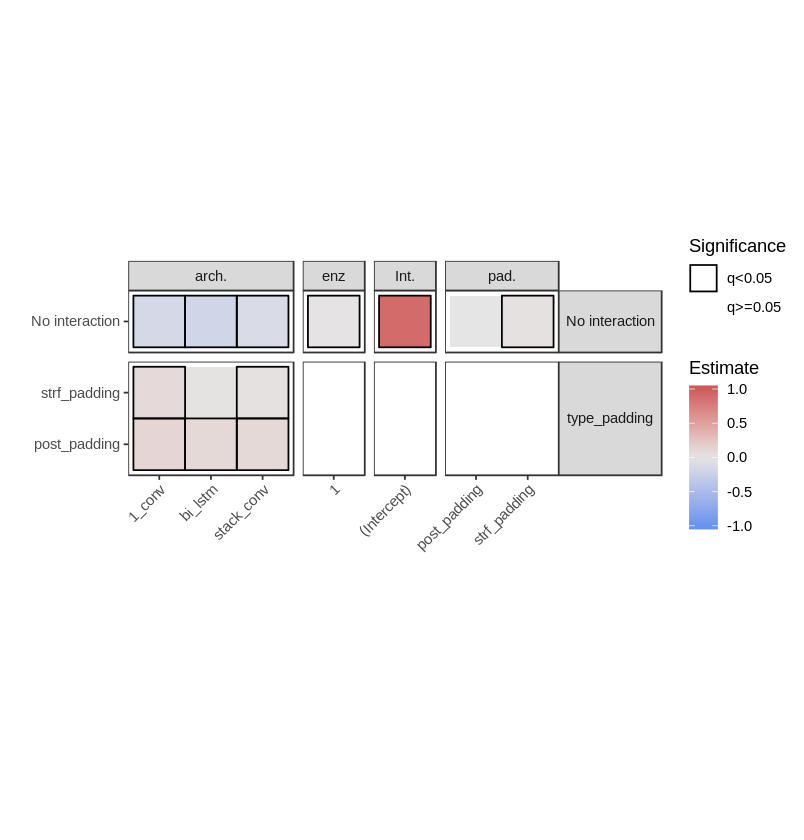

In [343]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g6_task1 <- plot_coefs_inter(lm_f1_task1_soa6)
g6_task1
ggsave("augPadding.eps", device="eps", path=file_path)

In [344]:
sm6_df <- postproc_lm(lm_f1_task1_soa6)
sm6_df_proc <- separating_interactions("architecture", "type_padding", sm6_df)

In [345]:
# Dividing lm in representable tiles
arch_df_6 <- dividing_rownames("architecture", sm6_df_proc$estimates_df)
enz_df_6 <- dividing_rownames("enz_type", sm6_df_proc$estimates_df)
pad_df_6 <- dividing_rownames("type_padding", sm6_df_proc$estimates_df)

In [346]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("architecture", arch_df_6)

In [347]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df_6)

In [348]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("enz_type", enz_df_6)

In [349]:
#options(repr.plot.width=4, repr.plot.height=3)
#plotting_interactions(sm6_df_proc)

## cómo afecta el tipo de enzima solo tiene sentido para la task 2

# Task 2

In [350]:
task <- "task2/"

path_scores_task2 <- paste0(absPath, "data/results/", task, file_scores)
#path_accu_task2 <- paste0(absPath, "data/results/", task, file_accuracy)

scores_task2 <- read.csv(file=path_scores_task2, header=TRUE, sep=",")
#accu_task2 <- read.csv(file=path_accu_task2, header=TRUE, sep=",")

## Scores

In [351]:
scores_task2[0:5,]
dim(scores_task2)
scores_task2$X <- NULL

#filtering 
scores_task2 <- scores_task2[scores_task2$enz_type %in% c(1,2,3,4,5,6,7),]
dim(scores_task2)
sapply(scores_task2, class)

# habria que hacer un unmelt de variable-value
scores_task2_dcasted <- dcast(data = scores_task2, formula = enz_type+index+type_padding+architecture~variable,
                              fun.aggregate = sum,value.var = "value")

#tengo que cambiar el nombre de f1-score
colnames(scores_task2_dcasted) <- c("enz_type", "index", "type_padding", "architecture", "f1_score",
                                    "precision", "recall")
scores_task2_dcasted[0:5,]

X,enz_type,index,type_padding,architecture,variable,value
<int>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>
0,1,0,post_padding,1_conv,f1-score,0.4609665
1,2,0,post_padding,1_conv,f1-score,0.6056475
2,3,0,post_padding,1_conv,f1-score,0.5493562
3,4,0,post_padding,1_conv,f1-score,0.4986877
4,5,0,post_padding,1_conv,f1-score,0.6060606


[1] 9600    7

[1] 6720    6

enz_type        index type_padding architecture     variable        value 
    "factor"    "integer"     "factor"     "factor"     "factor"    "numeric"

enz_type,index,type_padding,architecture,f1_score,precision,recall
<fct>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,0,aug_padding,1_conv,0.4514306,0.4031546,0.51284109
1,0,aug_padding,bi_lstm,0.1046196,0.3407080,0.06179775
1,0,aug_padding,only_denses,0.4247295,0.3453997,0.55136437
1,0,aug_padding,stack_conv,0.4891587,0.5320755,0.45264848
1,0,ext_padding,1_conv,0.3833866,0.2678571,0.67415730


## changing reference values

In [352]:
scores_task2_dcasted$architecture <- relevel(scores_task2_dcasted$architecture, "only_denses")
scores_task2_dcasted$type_padding <- relevel(scores_task2_dcasted$type_padding, "post_padding")

## defining "complete" lm task 1 (Additive)

In [353]:
lm_f1_task2_additive <- lm(f1_score~architecture+enz_type+type_padding, data=scores_task2_dcasted)

summary(lm_f1_task2_additive)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding, 
    data = scores_task2_dcasted)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.51449 -0.05887 -0.00777  0.04113  0.40756 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.4422464  0.0090377  48.934  < 2e-16 ***
architecture1_conv        0.0206864  0.0061998   3.337 0.000862 ***
architecturebi_lstm      -0.4157025  0.0061998 -67.051  < 2e-16 ***
architecturestack_conv    0.0101555  0.0061998   1.638 0.101557    
enz_type2                 0.2559840  0.0082016  31.212  < 2e-16 ***
enz_type3                 0.0938845  0.0082016  11.447  < 2e-16 ***
enz_type4                 0.0039705  0.0082016   0.484 0.628352    
enz_type5                 0.1226206  0.0082016  14.951  < 2e-16 ***
enz_type6                 0.0426076  0.0082016   5.195 2.23e-07 ***
enz_type7                 0.0722387  0.0082016   8.808  < 2e-16 ***
type_paddingaug_padding  -0.

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


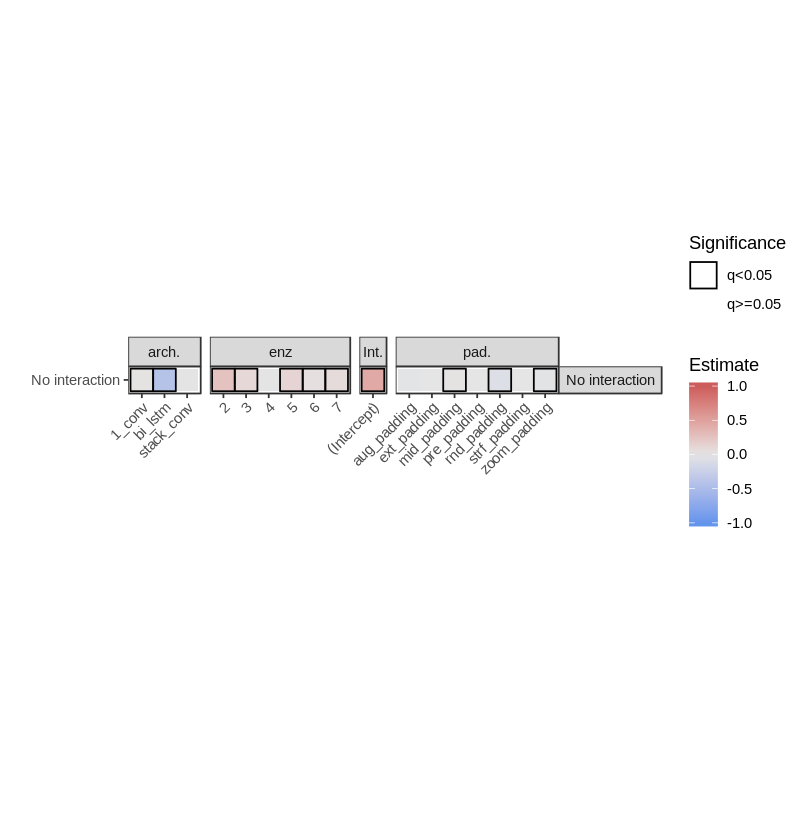

In [354]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g1_task2 <- plot_coefs_inter(lm_f1_task2_additive)
g1_task2

ggsave("full_additive.eps", device="eps", path=file_path)

In [355]:
sm1_df2 <- postproc_lm(lm_f1_task2_additive)
sm1_df2

# Dividing lm in representable tiles
arch_df2_1 <- dividing_rownames("architecture", sm1_df2)
enz_df2_1 <- dividing_rownames("enz_type", sm1_df2)
pad_df2_1 <- dividing_rownames("type_padding", sm1_df2)

,Estimate,Std.Error,t.value,p_val,p_adjusted
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.4422464340,0.009037700,48.93351823,0.000000e+00,0.000000e+00
architecture1_conv,0.0206864331,0.006199811,3.33662334,8.619870e-04,1.628198e-03
architecturebi_lstm,-0.4157025061,0.006199811,-67.05083831,0.000000e+00,0.000000e+00
architecturestack_conv,0.0101554714,0.006199811,1.63802927,1.015571e-01,1.328055e-01
enz_type2,0.2559839638,0.008201579,31.21154769,1.157582e-177,6.559630e-177
enz_type3,0.0938845446,0.008201579,11.44713090,1.603864e-29,5.453139e-29
enz_type4,0.0039705100,0.008201579,0.48411533,6.283517e-01,7.629985e-01
enz_type5,0.1226205896,0.008201579,14.95085210,3.131778e-48,1.331006e-47
enz_type6,0.0426075747,0.008201579,5.19504554,2.233191e-07,4.745532e-07


In [356]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("architecture", arch_df2_1)

In [357]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("enz_type", enz_df2_1)

In [358]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df2_1)

## in SoA models, are dense paddings the same?

In [359]:
soa_arch <- c("stack_conv", "bi_lstm")
soa_pad <- c("post_padding", "pre_padding", "mid_padding", "ext_padding")
lm_f1_task2_additive_soa <- lm(f1_score~architecture+enz_type+type_padding+type_padding:architecture,
                               data=subset(scores_task2_dcasted, architecture %in% soa_arch &
                                          type_padding %in% soa_pad))
summary(lm_f1_task2_additive_soa)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding + 
    type_padding:architecture, data = subset(scores_task2_dcasted, 
    architecture %in% soa_arch & type_padding %in% soa_pad))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.20633 -0.06346 -0.01382  0.05131  0.36483 

Coefficients:
                                                Estimate Std. Error t value
(Intercept)                                     0.020241   0.016375   1.236
architecturestack_conv                          0.443730   0.017505  25.349
enz_type2                                       0.344084   0.016375  21.013
enz_type3                                       0.109937   0.016375   6.714
enz_type4                                      -0.008815   0.016375  -0.538
enz_type5                                       0.065530   0.016375   4.002
enz_type6                                       0.057103   0.016375   3.487
enz_type7                                       0.059785   0.016375   3

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


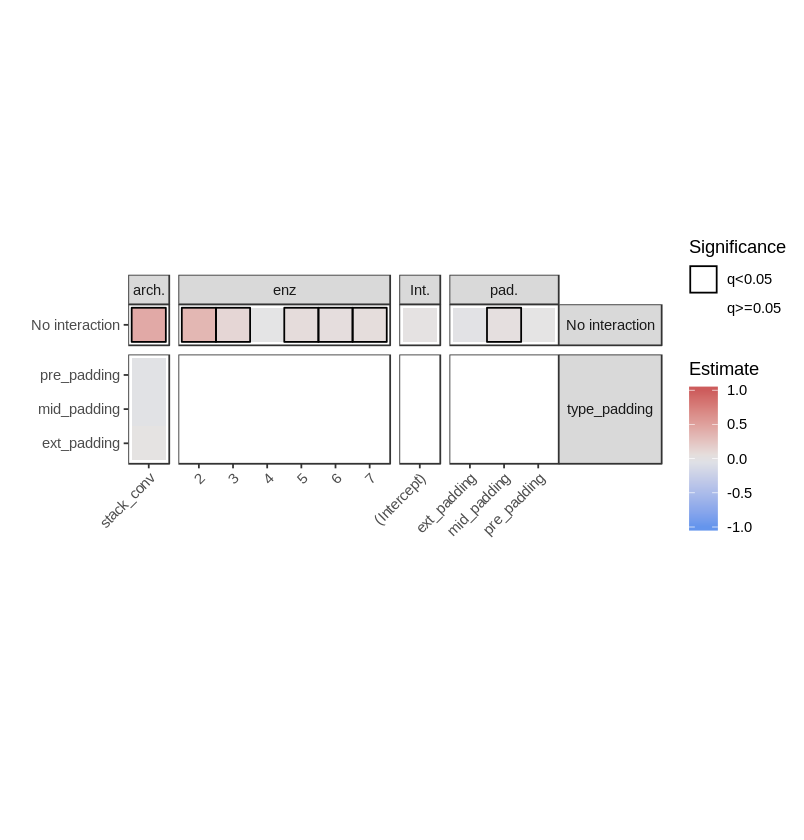

In [360]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g2_task2 <- plot_coefs_inter(lm_f1_task2_additive_soa)
g2_task2

ggsave("soa_densePadding.eps", device="eps", path=file_path)

In [361]:
sm2_df2 <- postproc_lm(lm_f1_task2_additive_soa)
sm2_df2_proc <- separating_interactions("architecture", "type_padding", sm2_df2)

In [362]:
# Dividing lm in representable tiles
arch_df2_2 <- dividing_rownames("architecture", sm2_df2_proc$estimates_df)
enz_df2_2 <- dividing_rownames("enz_type", sm2_df2_proc$estimates_df)
pad_df2_2 <- dividing_rownames("type_padding", sm2_df2_proc$estimates_df)

In [363]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("architecture", arch_df2_2)

In [364]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("enz_type", enz_df2_2)

In [365]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df2_2)

In [366]:
#options(repr.plot.width=4, repr.plot.height=3)
#plotting_interactions(sm2_df2_proc)

## effect of sparse padding to state of the art architectures?

In [367]:
soa2_pad <- c("post_padding", "strf_padding", "rnd_padding", "zoom_padding")
lm_f1_task2_additive_soa3 <- lm(f1_score~architecture+enz_type+type_padding+type_padding:architecture,
                               data=subset(scores_task2_dcasted, architecture %in% soa_arch &
                                          type_padding %in% soa2_pad))

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


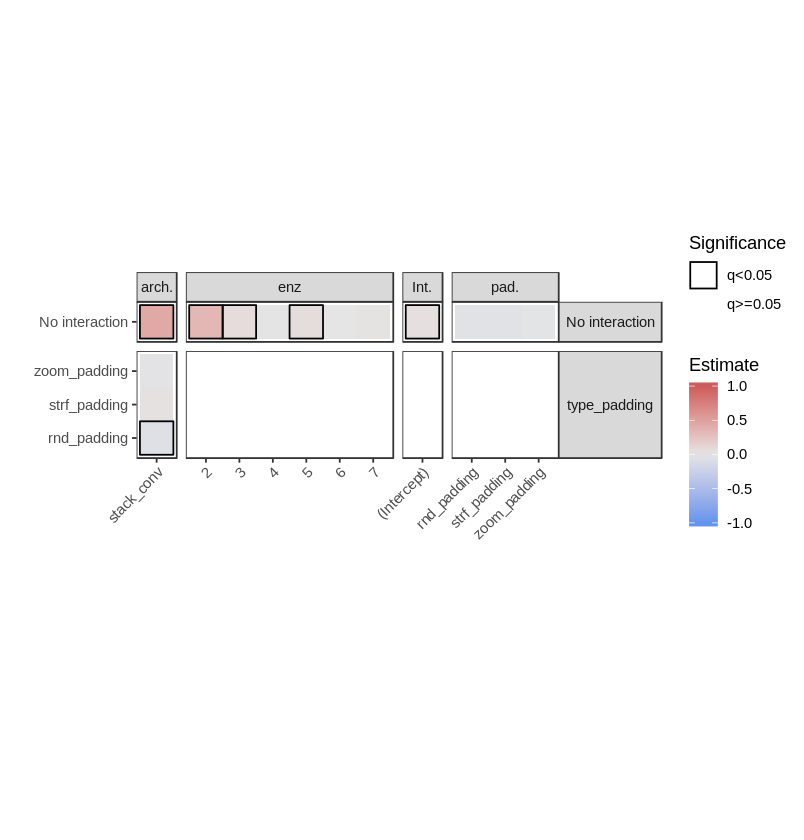

In [368]:
file_path <- paste0(absPath, "data/results/", "task2/", "linear_models_f1/")

g3_task2 <- plot_coefs_inter(lm_f1_task2_additive_soa3)
g3_task2 

ggsave("soa_sparsePadding.eps", device="eps", path=file_path)

In [369]:
summary(lm_f1_task2_additive_soa3)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding + 
    type_padding:architecture, data = subset(scores_task2_dcasted, 
    architecture %in% soa_arch & type_padding %in% soa2_pad))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.40811 -0.04638 -0.00637  0.04437  0.37064 

Coefficients:
                                                  Estimate Std. Error t value
(Intercept)                                      0.0405106  0.0150445   2.693
architecturestack_conv                           0.4437296  0.0160832  27.590
enz_type2                                        0.3422050  0.0150445  22.746
enz_type3                                        0.0662313  0.0150445   4.402
enz_type4                                       -0.0078110  0.0150445  -0.519
enz_type5                                        0.0633978  0.0150445   4.214
enz_type6                                       -0.0003121  0.0150445  -0.021
enz_type7                                        0.022

In [370]:
sm3_df2 <- postproc_lm(lm_f1_task2_additive_soa3)
sm3_df2_proc <- separating_interactions("architecture", "type_padding", sm3_df2)

#Dividing lm in representable tiles
arch_df2_3 <- dividing_rownames("architecture", sm3_df2_proc$estimates_df)
enz_df2_3 <- dividing_rownames("enz_type", sm3_df2_proc$estimates_df)
pad_df2_3 <- dividing_rownames("type_padding", sm3_df2_proc$estimates_df)

In [371]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("architecture", arch_df2_3)

In [372]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("enz_type", enz_df2_3)

In [373]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df2_3)

In [374]:
#options(repr.plot.width=4, repr.plot.height=3)
#plotting_interactions(sm3_df2_proc)

## differences between types of padding? 

In [375]:
lm_f1_task2_additive_soa4 <- lm(f1_score~enz_type+type_padding, 
                                data=subset(scores_task2_dcasted, architecture=="only_denses"))

summary(lm_f1_task2_additive_soa4)


Call:
lm(formula = f1_score ~ enz_type + type_padding, data = subset(scores_task2_dcasted, 
    architecture == "only_denses"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.49560 -0.03289  0.00192  0.03583  0.43419 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.43554    0.01546  28.170  < 2e-16 ***
enz_type2                 0.15236    0.01546   9.854  < 2e-16 ***
enz_type3                 0.10727    0.01546   6.938 1.13e-11 ***
enz_type4                 0.00524    0.01546   0.339 0.734809    
enz_type5                 0.16644    0.01546  10.765  < 2e-16 ***
enz_type6                 0.05805    0.01546   3.754 0.000192 ***
enz_type7                 0.02208    0.01546   1.428 0.153929    
type_paddingaug_padding   0.02269    0.01653   1.373 0.170354    
type_paddingext_padding   0.03393    0.01653   2.053 0.040543 *  
type_paddingmid_padding   0.03373    0.01653   2.041 0.041749 *  
type_paddingpre_padding   

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


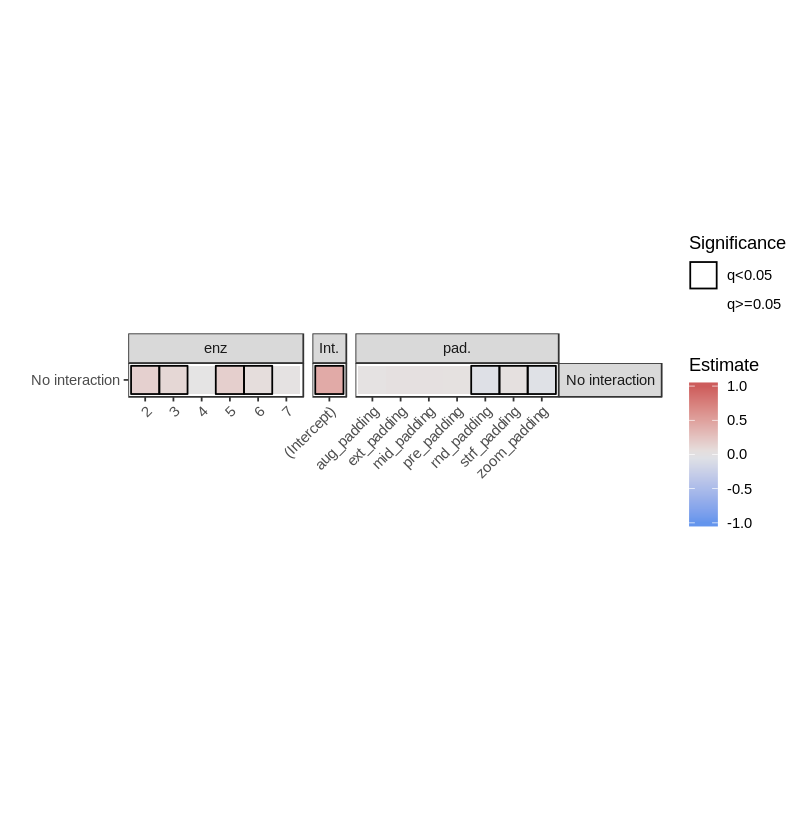

In [376]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g4_task2 <- plot_coefs_inter(lm_f1_task2_additive_soa4)
g4_task2

ggsave("typesPadding.eps", device="eps", path=file_path)

In [377]:
sm4_df2 <- postproc_lm(lm_f1_task2_additive_soa4)

enz_df2_4 <- dividing_rownames("enz_type", sm4_df2)
pad_df2_4 <- dividing_rownames("type_padding", sm4_df2)

In [378]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("enz_type", enz_df2_4)

In [379]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df2_4)

## mejoran las capas convolucionales la performance de los modelos?

In [380]:
soa_pad <- c("post_padding", "strf_padding")
lm_f1_task2_soa5 <- lm(f1_score~architecture+enz_type+type_padding+type_padding:architecture, 
                               data=subset(scores_task2_dcasted, type_padding %in% soa_pad))
summary(lm_f1_task2_soa5)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding + 
    type_padding:architecture, data = subset(scores_task2_dcasted, 
    type_padding %in% soa_pad))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.51926 -0.05773 -0.00332  0.04109  0.38064 

Coefficients:
                                                Estimate Std. Error t value
(Intercept)                                      0.42715    0.01598  26.736
architecture1_conv                               0.04128    0.01708   2.417
architecturebi_lstm                             -0.39870    0.01708 -23.343
architecturestack_conv                           0.04503    0.01708   2.636
enz_type2                                        0.25161    0.01598  15.749
enz_type3                                        0.09749    0.01598   6.102
enz_type4                                       -0.01585    0.01598  -0.992
enz_type5                                        0.10563    0.01598   6.612
enz_type6               

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


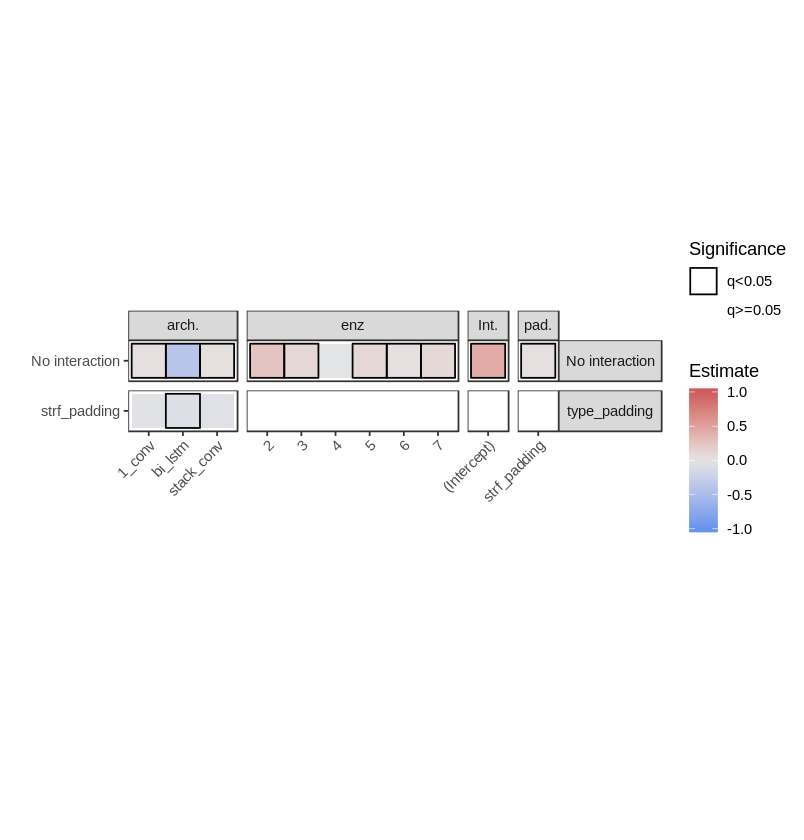

In [381]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g5_task2 <- plot_coefs_inter(lm_f1_task2_soa5)
g5_task2

ggsave("convLayers.eps", device="eps", path=file_path)

In [382]:
sm5_df2 <- postproc_lm(lm_f1_task2_soa5)
sm5_df2_proc <- separating_interactions("architecture", "type_padding", sm5_df2)

In [383]:
arch_df2_5 <- dividing_rownames("architecture", sm5_df2_proc$estimates_df)
enz_df2_5 <- dividing_rownames("enz_type", sm5_df2_proc$estimates_df)
pad_df2_5 <- dividing_rownames("type_padding", sm5_df2_proc$estimates_df)

In [384]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("architecture", arch_df2_5)

In [385]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("enz_type", enz_df2_5)

In [386]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df2_5)

In [387]:
#options(repr.plot.width=4, repr.plot.height=3)
#plotting_interactions(sm5_df2_proc)

## tiene aug_padding un buen efecto?

In [388]:
soa_pad <- c("post_padding", "strf_padding", "aug_padding")
scores_task2_dcasted_aug <- scores_task2_dcasted
scores_task2_dcasted_aug$type_padding <- relevel(scores_task2_dcasted_aug$type_padding, "aug_padding")
lm_f1_task2_soa6 <- lm(f1_score~architecture+enz_type+type_padding+type_padding:architecture, 
                               data=subset(scores_task2_dcasted_aug, type_padding %in% soa_pad))
summary(lm_f1_task2_soa6)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding + 
    type_padding:architecture, data = subset(scores_task2_dcasted_aug, 
    type_padding %in% soa_pad))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.51669 -0.05483 -0.00686  0.03844  0.38321 

Coefficients:
                                                 Estimate Std. Error t value
(Intercept)                                      0.450800   0.014164  31.827
architecture1_conv                               0.004791   0.016355   0.293
architecturebi_lstm                             -0.442202   0.016355 -27.037
architecturestack_conv                          -0.027212   0.016355  -1.664
enz_type2                                        0.252614   0.012492  20.223
enz_type3                                        0.087289   0.012492   6.988
enz_type4                                       -0.001736   0.012492  -0.139
enz_type5                                        0.111277   0.012492   8.908
enz_type6  

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


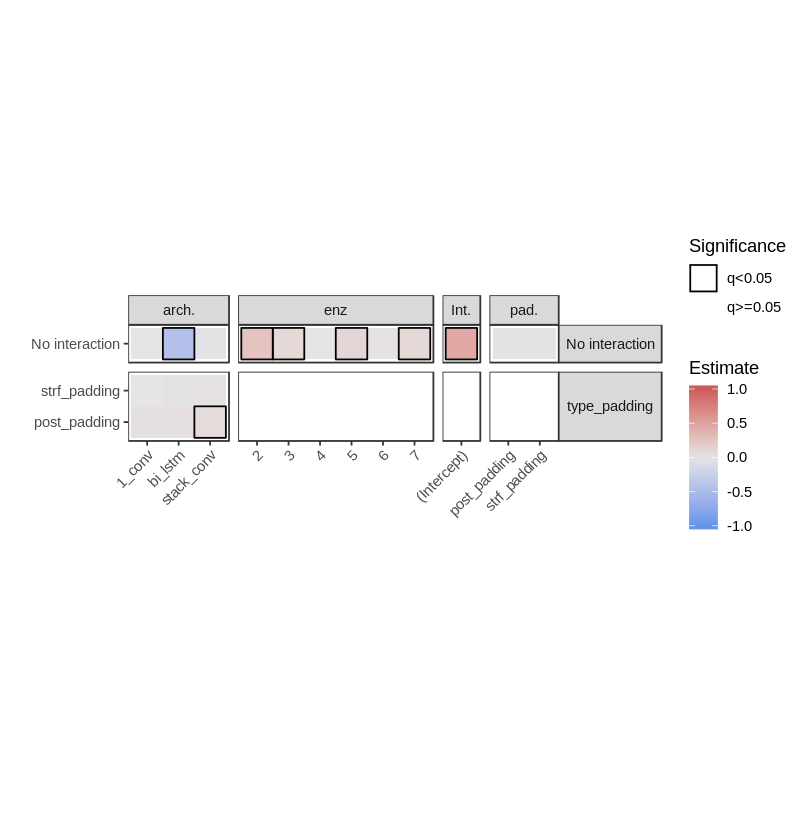

In [389]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g6_task2 <- plot_coefs_inter(lm_f1_task2_soa6)
g6_task2

ggsave("augPadding.eps", device="eps", path=file_path)

In [390]:
sm6_df2 <- postproc_lm(lm_f1_task2_soa6)
sm6_df2_proc <- separating_interactions ("architecture", "type_padding", sm6_df2)

arch_df2_6 <- dividing_rownames("architecture", sm6_df2_proc$estimates_df)
enz_df2_6 <- dividing_rownames("enz_type", sm6_df2_proc$estimates_df)
pad_df2_6 <- dividing_rownames("type_padding", sm6_df2_proc$estimates_df)

In [391]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("architecture", arch_df2_6)

In [392]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("enz_type", enz_df2_6)

In [393]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df2_6)

In [394]:
#options(repr.plot.width=4, repr.plot.height=3)
#plotting_interactions(sm6_df2_proc)

## cómo afecta el tipo de enzima?

In [395]:
soa_pad <- c("post_padding", "strf_padding")
lm_f1_task2_soa7 <- lm(f1_score~architecture+enz_type+type_padding+type_padding*enz_type, 
                               data=subset(scores_task2_dcasted, type_padding %in% soa_pad))
summary(lm_f1_task2_soa7)


Call:
lm(formula = f1_score ~ architecture + enz_type + type_padding + 
    type_padding * enz_type, data = subset(scores_task2_dcasted, 
    type_padding %in% soa_pad))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.54052 -0.05846 -0.00198  0.04155  0.37911 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         0.436241   0.017708  24.636  < 2e-16 ***
architecture1_conv                  0.021552   0.012147   1.774   0.0766 .  
architecturebi_lstm                -0.435676   0.012147 -35.866  < 2e-16 ***
architecturestack_conv              0.021744   0.012147   1.790   0.0740 .  
enz_type2                           0.253662   0.022726  11.162  < 2e-16 ***
enz_type3                           0.128460   0.022726   5.653 2.55e-08 ***
enz_type4                          -0.002827   0.022726  -0.124   0.9011    
enz_type5                           0.105031   0.022726   4.622 4.76e-06 ***
enz_type6        

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


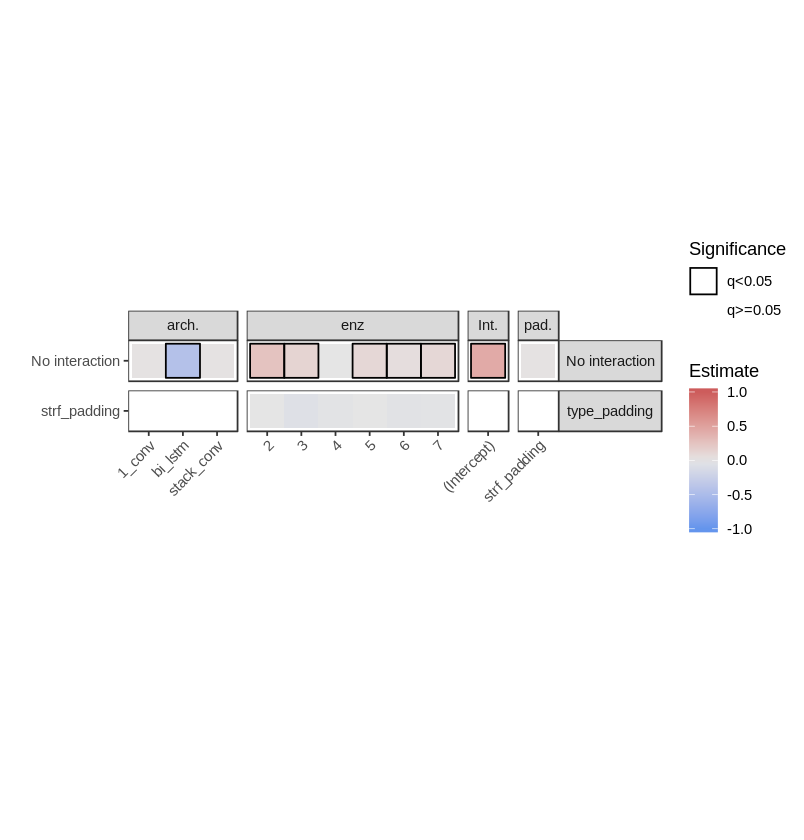

In [396]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g7_task2 <-plot_coefs_inter(lm_f1_task2_soa7)
g7_task2

ggsave("enzType.eps", device="eps", path=file_path)



In [397]:
sm7_df2 <- postproc_lm(lm_f1_task2_soa7)
sm7_df2_proc <- separating_interactions ("enz_type", "type_padding", sm7_df2)

arch_df2_7 <- dividing_rownames("architecture", sm7_df2_proc$estimates_df)
enz_df2_7 <- dividing_rownames("enz_type", sm7_df2_proc$estimates_df)
pad_df2_7 <- dividing_rownames("type_padding", sm7_df2_proc$estimates_df)

In [398]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("architecture", arch_df2_7)

In [399]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("enz_type", enz_df2_7)

In [400]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df2_7)

In [401]:
#options(repr.plot.width=4, repr.plot.height=3)
#plotting_interactions(sm7_df2_proc)

## Construyendo tablas

## Full additive models

In [402]:
stargazer::stargazer(lm_f1_task1_additive, lm_f1_task2_additive,   
          column.labels = c("Task 1", "Task 2"), 
  model.numbers = FALSE,
  ci = TRUE, ci.level = 0.95, 
  single.row = TRUE, omit.table.layout = "mdl", 
  label = "tab:lm_full_additive",
  title = "Full additive linear models on F1-score. The reference levels were omitted.", 
  type = 'latex'
          #,out = paste0(dir_out, "/1_cv_models.tex"
         )


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Tue, Nov 05, 2019 - 07:26:14 PM
\begin{table}[!htbp] \centering 
  \caption{Full additive linear models on F1-score. The reference levels were omitted.} 
  \label{tab:lm_full_additive} 
\begin{tabular}{@{\extracolsep{5pt}}lcc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Task 1 & Task 2 \\ 
 architecture1\_conv & $-$0.063$^{***}$ ($-$0.073, $-$0.054) & 0.021$^{***}$ (0.009, 0.033) \\ 
  architecturebi\_lstm & $-$0.144$^{***}$ ($-$0.154, $-$0.134) & $-$0.416$^{***}$ ($-$0.428, $-$0.404) \\ 
  architecturestack\_conv & $-$0.052$^{***}$ ($-$0.062, $-$0.043) & 0.010 ($-$0.002, 0.022) \\ 
  enz\_type1 & 0.024$^{***}$ (0.017, 0.031) &  \\ 
  enz\_type2 &  & 0.256$^{***}$ (0.240, 0.272) \\ 
  enz\_type3 &  & 0.094$^{***}$ (0.078, 0.110) \\ 
  enz\_type4 &  & 0.004 ($-$0.012, 0.020) \\ 
  enz\_type5 &  & 0.123$^{***}$ (0.107, 0.139) \\ 
  enz\_type6 &  & 0.043$^{***}$ (0.02

## SoA models: dense padding

In [403]:
stargazer::stargazer(lm_f1_task1_additive_soa, lm_f1_task2_additive_soa,   
          column.labels = c("Task 1", "Task 2"), 
  model.numbers = FALSE,
  ci = TRUE, ci.level = 0.95, 
  single.row = TRUE, omit.table.layout = "mdl", 
  label = "tab:soa_dense",
  title = "Linear model on F1-score to analyze how dense padding affects to state of the art models. The reference levels were omitted.", 
  type = 'latex'
          #,out = paste0(dir_out, "/1_cv_models.tex"
         )


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Tue, Nov 05, 2019 - 07:26:14 PM
\begin{table}[!htbp] \centering 
  \caption{Linear model on F1-score to analyze how dense padding affects to state of the art models. The reference levels were omitted.} 
  \label{tab:soa_dense} 
\begin{tabular}{@{\extracolsep{5pt}}lcc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Task 1 & Task 2 \\ 
 architecturestack\_conv & 0.080$^{***}$ (0.043, 0.117) & 0.444$^{***}$ (0.409, 0.478) \\ 
  enz\_type1 & 0.045$^{***}$ (0.026, 0.063) &  \\ 
  enz\_type2 &  & 0.344$^{***}$ (0.312, 0.376) \\ 
  enz\_type3 &  & 0.110$^{***}$ (0.078, 0.142) \\ 
  enz\_type4 &  & $-$0.009 ($-$0.041, 0.023) \\ 
  enz\_type5 &  & 0.066$^{***}$ (0.033, 0.098) \\ 
  enz\_type6 &  & 0.057$^{***}$ (0.025, 0.089) \\ 
  enz\_type7 &  & 0.060$^{***}$ (0.028, 0.092) \\ 
  type\_paddingext\_padding & $-$0.143$^{***}$ ($-$0.180, $-$0.106) & $-$0.031$^{*}$ ($-$0.065, 0.

## SoA models: sparse padding

In [404]:
stargazer::stargazer(lm_f1_task1_additive_soa3, lm_f1_task2_additive_soa3,   
          column.labels = c("Task 1", "Task 2"), 
  model.numbers = FALSE,
  ci = TRUE, ci.level = 0.95, 
  single.row = TRUE, omit.table.layout = "mdl", 
  label = "tab:soa_sparse",
  title = "Linear model on F1-score to analyze how sparse padding affects to state of the art models. The reference levels were omitted.", 
  type = 'latex'
          #,out = paste0(dir_out, "/1_cv_models.tex"
         )


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Tue, Nov 05, 2019 - 07:26:14 PM
\begin{table}[!htbp] \centering 
  \caption{Linear model on F1-score to analyze how sparse padding affects to state of the art models. The reference levels were omitted.} 
  \label{tab:soa_sparse} 
\begin{tabular}{@{\extracolsep{5pt}}lcc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Task 1 & Task 2 \\ 
 architecturestack\_conv & 0.080$^{***}$ (0.066, 0.094) & 0.444$^{***}$ (0.412, 0.475) \\ 
  enz\_type1 & 0.047$^{***}$ (0.040, 0.054) &  \\ 
  enz\_type2 &  & 0.342$^{***}$ (0.313, 0.372) \\ 
  enz\_type3 &  & 0.066$^{***}$ (0.037, 0.096) \\ 
  enz\_type4 &  & $-$0.008 ($-$0.037, 0.022) \\ 
  enz\_type5 &  & 0.063$^{***}$ (0.034, 0.093) \\ 
  enz\_type6 &  & $-$0.0003 ($-$0.030, 0.029) \\ 
  enz\_type7 &  & 0.022 ($-$0.007, 0.052) \\ 
  type\_paddingrnd\_padding & $-$0.052$^{***}$ ($-$0.067, $-$0.038) & $-$0.034$^{**}$ ($-$0.066, $-$0.

## differences between types of padding?

In [405]:
stargazer::stargazer(lm_f1_task1_additive_soa4, lm_f1_task2_additive_soa4,   
          column.labels = c("Task 1", "Task 2"), 
  model.numbers = FALSE,
  ci = TRUE, ci.level = 0.95, 
  single.row = TRUE, omit.table.layout = "mdl", 
  label = "tab:typePadding",
  title = "Linear model on F1-score to analyze the differences between types of padding. The reference levels were omitted.", 
  type = 'latex'
          #,out = paste0(dir_out, "/1_cv_models.tex"
         )


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Tue, Nov 05, 2019 - 07:26:14 PM
\begin{table}[!htbp] \centering 
  \caption{Linear model on F1-score to analyze the differences between types of padding. The reference levels were omitted.} 
  \label{tab:typePadding} 
\begin{tabular}{@{\extracolsep{5pt}}lcc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Task 1 & Task 2 \\ 
 enz\_type1 & 0.009$^{***}$ (0.004, 0.014) &  \\ 
  enz\_type2 &  & 0.152$^{***}$ (0.122, 0.183) \\ 
  enz\_type3 &  & 0.107$^{***}$ (0.077, 0.138) \\ 
  enz\_type4 &  & 0.005 ($-$0.025, 0.036) \\ 
  enz\_type5 &  & 0.166$^{***}$ (0.136, 0.197) \\ 
  enz\_type6 &  & 0.058$^{***}$ (0.028, 0.088) \\ 
  enz\_type7 &  & 0.022 ($-$0.008, 0.052) \\ 
  type\_paddingaug\_padding & $-$0.0002 ($-$0.010, 0.010) & 0.023 ($-$0.010, 0.055) \\ 
  type\_paddingext\_padding & $-$0.004 ($-$0.014, 0.006) & 0.034$^{**}$ (0.002, 0.066) \\ 
  type\_paddingmid\_padding &

## do convolutional layers improve models performance?

In [406]:
stargazer::stargazer(lm_f1_task1_soa5, lm_f1_task2_soa5,   
          column.labels = c("Task 1", "Task 2"), 
  model.numbers = FALSE,
  ci = TRUE, ci.level = 0.95, 
  single.row = TRUE, omit.table.layout = "mdl", 
  label = "tab:convLayer",
  title = "Linear model on F1-score to analyze if adding convolutional layers improve the performance. The reference levels were omitted.", 
  type = 'latex'
          #,out = paste0(dir_out, "/1_cv_models.tex"
         )


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Tue, Nov 05, 2019 - 07:26:15 PM
\begin{table}[!htbp] \centering 
  \caption{Linear model on F1-score to analyze if adding convolutional layers improve the performance. The reference levels were omitted.} 
  \label{tab:convLayer} 
\begin{tabular}{@{\extracolsep{5pt}}lcc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Task 1 & Task 2 \\ 
 architecture1\_conv & $-$0.027$^{***}$ ($-$0.040, $-$0.015) & 0.041$^{**}$ (0.008, 0.075) \\ 
  architecturebi\_lstm & $-$0.101$^{***}$ ($-$0.114, $-$0.088) & $-$0.399$^{***}$ ($-$0.432, $-$0.365) \\ 
  architecturestack\_conv & $-$0.021$^{***}$ ($-$0.034, $-$0.008) & 0.045$^{***}$ (0.012, 0.079) \\ 
  enz\_type1 & 0.027$^{***}$ (0.021, 0.033) &  \\ 
  enz\_type2 &  & 0.252$^{***}$ (0.220, 0.283) \\ 
  enz\_type3 &  & 0.097$^{***}$ (0.066, 0.129) \\ 
  enz\_type4 &  & $-$0.016 ($-$0.047, 0.015) \\ 
  enz\_type5 &  & 0.106$^{***}$ (0.07

## what is the effect of aug_padding? 

In [407]:
stargazer::stargazer(lm_f1_task1_soa6, lm_f1_task2_soa6,   
          column.labels = c("Task 1", "Task 2"), 
  model.numbers = FALSE,
  ci = TRUE, ci.level = 0.95, 
  single.row = TRUE, omit.table.layout = "mdl", 
  label = "tab:augPadding",
  title = "Linear model on F1-score to study if an ensemble of paddings is beneficial. The reference levels were omitted.", 
  type = 'latex'
          #,out = paste0(dir_out, "/1_cv_models.tex"
         )


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Tue, Nov 05, 2019 - 07:26:15 PM
\begin{table}[!htbp] \centering 
  \caption{Linear model on F1-score to study if an ensemble of paddings is beneficial. The reference levels were omitted.} 
  \label{tab:augPadding} 
\begin{tabular}{@{\extracolsep{5pt}}lcc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Task 1 & Task 2 \\ 
 architecture1\_conv & $-$0.144$^{***}$ ($-$0.163, $-$0.125) & 0.005 ($-$0.027, 0.037) \\ 
  architecturebi\_lstm & $-$0.187$^{***}$ ($-$0.206, $-$0.168) & $-$0.442$^{***}$ ($-$0.474, $-$0.410) \\ 
  architecturestack\_conv & $-$0.110$^{***}$ ($-$0.129, $-$0.091) & $-$0.027$^{*}$ ($-$0.059, 0.005) \\ 
  enz\_type1 & 0.012$^{***}$ (0.004, 0.020) &  \\ 
  enz\_type2 &  & 0.253$^{***}$ (0.228, 0.277) \\ 
  enz\_type3 &  & 0.087$^{***}$ (0.063, 0.112) \\ 
  enz\_type4 &  & $-$0.002 ($-$0.026, 0.023) \\ 
  enz\_type5 &  & 0.111$^{***}$ (0.087, 0.136) \\ 
 

## cómo afecta el tipo de enzima?

In [408]:
stargazer::stargazer(lm_f1_task2_soa7,   
          column.labels = c("Task 2"), 
  model.numbers = FALSE,
  ci = TRUE, ci.level = 0.95, 
  single.row = TRUE, omit.table.layout = "mdl", 
  label = "tab:enz_type",
  title = "Linear model on F1-score to analyze if enzyme type affects to the model performance. The reference levels were omitted.", 
  type = 'latex'
          #,out = paste0(dir_out, "/1_cv_models.tex"
         )


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Tue, Nov 05, 2019 - 07:26:15 PM
\begin{table}[!htbp] \centering 
  \caption{Linear model on F1-score to analyze if enzyme type affects to the model performance. The reference levels were omitted.} 
  \label{tab:enz_type} 
\begin{tabular}{@{\extracolsep{5pt}}lc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Task 2 \\ 
 architecture1\_conv & 0.022$^{*}$ ($-$0.002, 0.045) \\ 
  architecturebi\_lstm & $-$0.436$^{***}$ ($-$0.459, $-$0.412) \\ 
  architecturestack\_conv & 0.022$^{*}$ ($-$0.002, 0.046) \\ 
  enz\_type2 & 0.254$^{***}$ (0.209, 0.298) \\ 
  enz\_type3 & 0.128$^{***}$ (0.084, 0.173) \\ 
  enz\_type4 & $-$0.003 ($-$0.047, 0.042) \\ 
  enz\_type5 & 0.105$^{***}$ (0.060, 0.150) \\ 
  enz\_type6 & 0.058$^{**}$ (0.013, 0.102) \\ 
  enz\_type7 & 0.104$^{***}$ (0.060, 0.149) \\ 
  type\_paddingstrf\_padding & 0.022 ($-$0.023, 0.066) \\ 
  enz\_type2:type\_paddingstrf

## Grobbing

## Full model

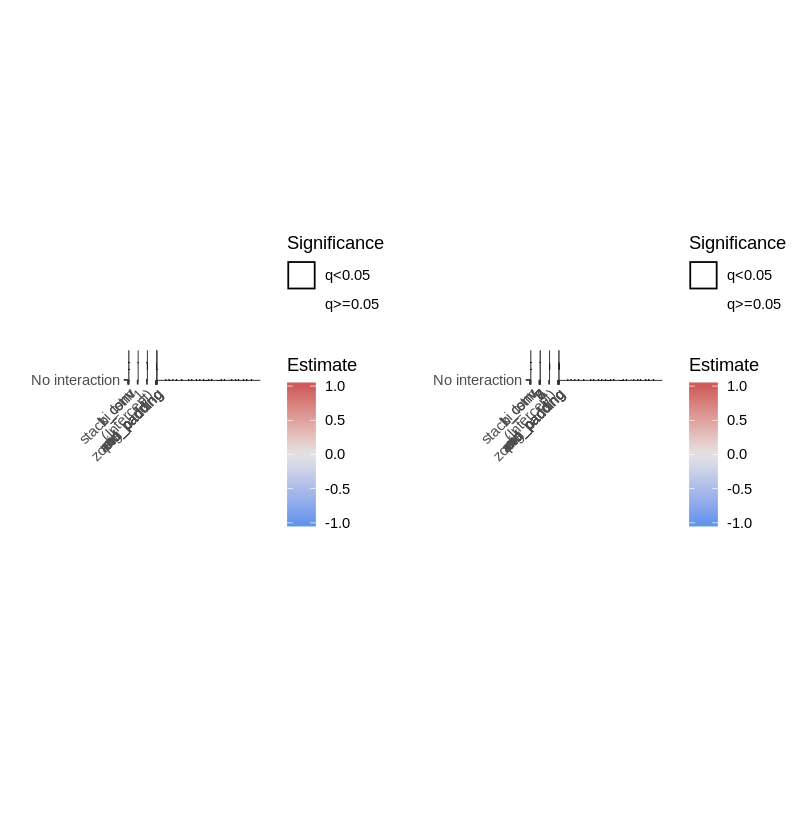

In [409]:
options(repr.plot.width=6.7)
gs = list(ggplotGrob(g1_task1), ggplotGrob(g1_task2))
grid.arrange(grobs = gs, ncol=2)